# Challenges with real data
In this lesson you will have the chance to deal with simulated and data candidates generated and collected, respectively, by the LHCb experiment. The data has been preprocessed to facilitate the work with it, and a previous selection has been run in order to remove part of the background candidates in any of the cases.

In [1]:
%matplotlib inline
%run auxiliar/shared.ipynb
import hep_lessons_ml
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas

np.random.seed(4857) # so everybody gets the same results

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

## Selecting $K_\rm{S}^0\rightarrow\pi^+\pi^-$ candidates
This challenge is similar to what was done in the previous lesson, but on a more realistic situation. You must train a ML algorithm in order to discriminate the signal candidates from the data sample. To start, let's take a look at the distribution of the invariant mass in data and in simulation.

In [2]:
k0s2pi2_dt = sample_to_dataframe('data.hdf5', key='k0s2pi2', stop=None)
k0s2pi2_mc = sample_to_dataframe('k0s2pi2.hdf5', key='k0s2pi2', stop=None)

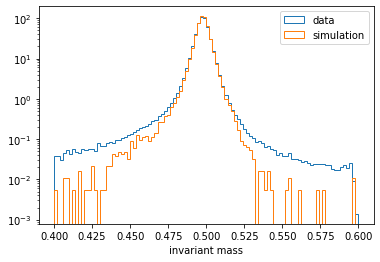

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(k0s2pi2_dt['head_m'], range=(0.4, 0.6), bins=100, density=True, histtype='step', label='data')
ax.hist(k0s2pi2_mc['head_m'], range=(0.4, 0.6), bins=100, density=True, histtype='step', label='simulation')
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('invariant mass');
ax.legend();

As you can see, in our data sample we have the signal peak laying over some background. The challenge is to remove this background taking an apropriate choice of proxies and variables.

The signal proxy in this case is composed by pure simulated $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ candidates. For background, we must use that of the data sample. As always, it is important to use a part of the sample that we will not process further in our analysis to avoid overtraining, or we will need to take into account all the biases that could be causing. For our case, we will take candidates from the far right sideband in the dipion invariant mass.

As in the previous lesson, we will train an adaptive boosted decision tree using characteristic variables of the decay, and check its performance.

In [4]:
k0s2pi2_dt.loc[:,'train'] = train_mask(k0s2pi2_dt)
k0s2pi2_mc.loc[:,'train'] = train_mask(k0s2pi2_mc)

k0s2pi2_dt.loc[:,'signal'] = False
k0s2pi2_mc.loc[:,'signal'] = True

columns = set(k0s2pi2_dt.columns).intersection(k0s2pi2_mc.columns) # common columns

k0s2pi2_sig = k0s2pi2_mc.copy()
k0s2pi2_bkg = k0s2pi2_dt[k0s2pi2_dt['head_m'] > 0.55].copy()

sample = pandas.concat([k0s2pi2_sig[columns], k0s2pi2_bkg[columns]])

In [5]:
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=0.1, max_features='auto'), learning_rate=0.2, n_estimators=50)

variables = ['head_doca', 'head_ip', 'p1_ip', 'p2_ip', 'head_pt', 'p1_pt', 'p2_pt']

classifier.fit(sample[sample['train']][variables], sample[sample['train']]['signal']);

sample.loc[:,'bkg_proba'], sample.loc[:,'sig_proba'] = classifier.predict_proba(sample[variables]).T

Area under curve: 0.9587852913919824


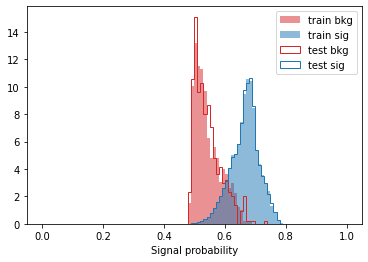

In [6]:
plot_overtraining('sig_proba', sample[sample['train']], sample[~sample['train']])

rauc = plot_roc('sig_proba', sample)

print(f'Area under curve: {rauc}')

The challenge is to improve this result by changing the variables, the definition of the background (use the two sidebands and see what happens), algorithm choice and configuration, ... It is time for you to make a decision!

## Selecting $K^0\rightarrow\pi\mu\nu$ candidates
This problem more complicated than the previous... but also more interesting from the physical point of view. The $K_\rm{S}^0 \rightarrow \pi\mu\nu$ decay has been recently discovered by the KLOE-2 collaboration

https://arxiv.org/abs/1912.05990

and you have the chance to see the contribution from this kind of decays here! The initial problem is that there is an overwhelming contribution from $K_\rm{S}^0\rightarrow\pi^+\pi^-$ candidates that are a dangerous background. On the other hand, there is also a big contribution of pions arising from inelastic material interactions that we can partially veto using the *matterveto* variable (we will latter include it in the classifier). Let's load the input samples, apply a loose selection, and look at the two-body invariant mass distribution.

In [7]:
k0s2pimunu_dt = sample_to_dataframe('data.hdf5', key='k0s2pimunu')
k0s2pimunu_mc = sample_to_dataframe('k0s2pimunu.hdf5', key='k0s2pimunu')
k0s2pi2_mc_vs = sample_to_dataframe('k0s2pi2.hdf5', key='k0s2pimunu')

k0s2pimunu_dt = k0s2pimunu_dt[k0s2pimunu_dt['matter_veto'] > 0.5]
k0s2pimunu_mc = k0s2pimunu_mc[k0s2pimunu_mc['matter_veto'] > 0.5]
k0s2pi2_mc_vs = k0s2pi2_mc_vs[k0s2pi2_mc_vs['matter_veto'] > 0.5]

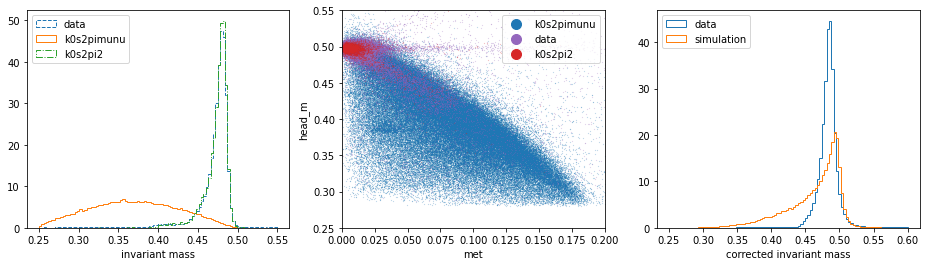

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4))

common = dict(range=(0.25, 0.55), bins=100, density=True, histtype='step')

ax0.hist(k0s2pimunu_dt['head_m'], label='data', linestyle='--', **common);
ax0.hist(k0s2pimunu_mc['head_m'], label='k0s2pimunu', **common);
ax0.hist(k0s2pi2_mc_vs['head_m'], label='k0s2pi2', linestyle='-.', **common);
ax0.set_xlabel('invariant mass');
ax0.legend(loc='upper left');

common = dict(marker='o', markersize=0.1, linestyle='none')

ax1.plot(k0s2pimunu_mc['met'], k0s2pimunu_mc['head_m_pipi'], color='C0', **common)
l0 = matplotlib.lines.Line2D([], [], marker='o', color='C0', ls='none', markersize=10)
ax1.plot(k0s2pimunu_dt['met'], k0s2pimunu_dt['head_m_pipi'], color='C4', **common)
l1 = matplotlib.lines.Line2D([], [], marker='o', color='C4', ls='none', markersize=10)
ax1.plot(k0s2pi2_mc_vs['met'], k0s2pi2_mc_vs['head_m_pipi'], color='C3', **common)
l2 = matplotlib.lines.Line2D([], [], marker='o', color='C3', ls='none', markersize=10)
ax1.set_xlim(0, 0.2)
ax1.set_ylim(0.25, 0.55)
ax1.set_ylabel('head_m')
ax1.set_xlabel('met')
ax1.legend([l0, l1, l2], ['k0s2pimunu', 'data', 'k0s2pi2'], loc='upper right');

common = dict(range=(0.25, 0.6), bins=100, density=True, histtype='step')

ax2.hist(k0s2pimunu_dt['head_m_corr'], label='data', **common)
ax2.hist(k0s2pimunu_mc['head_m_corr'], label='simulation', **common)
ax2.set_xlabel('corrected invariant mass')
ax2.legend(loc='upper left');

The two-body invariant mass of the $K^0\rightarrow\pi\mu\nu$ decay (taking the two charged particles) is not so peaky as for the $K_\rm{S}^0\rightarrow\pi^+\pi^-$ decay due to the missing energy of the neutrino, and the latter becomes a dangerous background. Fortunately, there are several tricks that will allow us to get rid of this component. We can use the information from the vertices (assuming that the $K_\rm{S}^0$ is produced in the Primary Vertex (PV) in order to kinematically constrain the decay, and get an estimate of the transverse energy that is lost due to the neutrino. In the middle plot you can appreciate the difference between distributions of the two-body invariant mass and the missing transverse energy for simulated $K^0\rightarrow\pi\mu\nu$ and $K_\rm{S}^0\rightarrow\pi^+\pi^-$ candidates. The missing energy can be used in order to correct the two-body invariant mass and get a more peaking structure for the $K^0\rightarrow\pi\mu\nu$ candidates (this is widely used at LHCb, for example).

In [9]:
mass_window = lambda s: (s['head_m_corr'] > 0.4) & (s['head_m_corr'] < 0.55)
mass_pipi = lambda s: s['head_m_pipi'] < 0.4
mass_plane = lambda s: ((s['head_m_pipi'] - 0.3) * 0.6 - 0.2 + s['met']) < 0

select = lambda s: mass_window(s) & mass_pipi(s) & mass_plane(s)

k0s2pimunu_dt_sel = k0s2pimunu_dt[select(k0s2pimunu_dt)]
k0s2pimunu_mc_sel = k0s2pimunu_mc[select(k0s2pimunu_mc)]
k0s2pi2_mc_vs_sel = k0s2pi2_mc_vs[select(k0s2pi2_mc_vs)]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

common = dict(range=(0.25, 0.55), bins=100, density=True, histtype='step')

ax0.hist(k0s2pimunu_dt_sel['head_m'], label='data', linestyle='--', **common);
ax0.hist(k0s2pimunu_mc_sel['head_m'], label='k0s2pimunu', **common);
ax0.hist(k0s2pi2_mc_vs_sel['head_m'], label='k0s2pi2', linestyle='-.', **common);
ax0.set_xlabel('invariant mass');
ax0.legend(loc='upper right');

common = dict(range=(0.25, 0.6), bins=100, density=True, histtype='step')

ax1.hist(k0s2pimunu_dt_sel['head_m_corr'], label='data', **common)
ax1.hist(k0s2pimunu_mc_sel['head_m_corr'], label='simulation', **common)
ax1.set_xlabel('corrected invariant mass')
ax1.legend(loc='upper left');

Now we have a more pure sample of $K^0\rightarrow\pi\mu\nu$ decays, but we still need to fight against the remaining background. We can proceed as we did before, using simulated candidates as a proxy for signal and data candidates from the right sideband (on the left we risk to get candidates from the tail of the signal) for background. We will use candidates before the previous selection is applied, so we have enough statistics to train the algorithm. The sample will be composed by candidates with a corrected invariant mass greater than $0.55~\text{GeV}/c^2$.

In [10]:
k0s2pimunu_sig = k0s2pimunu_mc_sel.copy()
k0s2pimunu_bkg = k0s2pimunu_dt[k0s2pimunu_dt['head_m_corr'] > 0.55].copy()

k0s2pimunu_sig.loc[:,'train'] = train_mask(k0s2pimunu_sig)
k0s2pimunu_bkg.loc[:,'train'] = train_mask(k0s2pimunu_bkg)

k0s2pimunu_bkg.loc[:,'signal'] = False
k0s2pimunu_sig.loc[:,'signal'] = True

columns = set(k0s2pimunu_bkg.columns).intersection(k0s2pimunu_sig.columns) # common columns

sample = pandas.concat([k0s2pimunu_sig[columns], k0s2pimunu_bkg[columns]])

In [11]:
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=0.1, max_features='auto'), learning_rate=0.2, n_estimators=50)

variables = ['head_doca', 'head_ip', 'p1_ip', 'p2_ip', 'head_pt', 'p1_pt', 'p2_pt', 'matter_veto']

classifier.fit(sample[sample['train']][variables], sample[sample['train']]['signal']);

sample.loc[:,'bkg_proba'], sample.loc[:,'sig_proba'] = classifier.predict_proba(sample[variables]).T

Area under curve: 0.9116750749248854


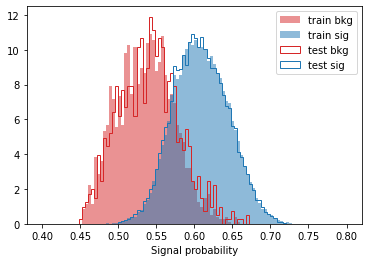

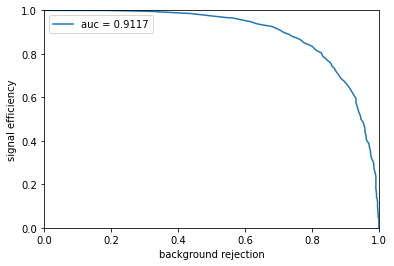

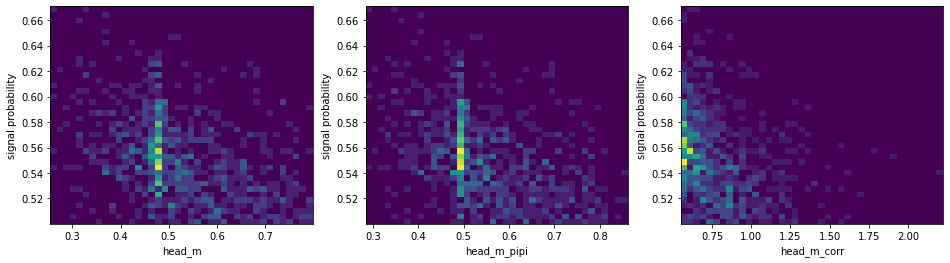

In [12]:
plot_overtraining('sig_proba', sample[sample['train']], sample[~sample['train']], range=(0.4, 0.8))

rauc = plot_roc('sig_proba', sample)

print(f'Area under curve: {rauc}')

# Correlation with the different mass variables
bkg = sample[~sample['signal'] & ~sample['train'] & (sample['sig_proba'] > 0.5)]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4))
ax0.hist2d(bkg['head_m'], bkg['sig_proba'], bins=(40, 40))
ax0.set_xlabel('head_m')
ax1.hist2d(bkg['head_m_pipi'], bkg['sig_proba'], bins=(40, 40))
ax1.set_xlabel('head_m_pipi')
ax2.hist2d(bkg['head_m_corr'], bkg['sig_proba'], bins=(40, 40))
ax2.set_xlabel('head_m_corr')

for ax in ax0, ax1, ax2:
    ax.set_ylabel('signal probability')

As before, the challenge is to improve this results and get a more pure sample of $K^0\rightarrow\pi\mu\nu$ decays.